# *Imports*

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split


#sklearn modules for Model Selection:
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#sklearn modules for Model Evaluation & Improvement:
    
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# *Dataset*

In [3]:
# 
from google.colab import files
uploaded = files.upload()

Saving takehome_ds_written.csv to takehome_ds_written.csv


In [7]:
def load_data(filename='takehome_ds_written.csv'):

  df = pd.read_csv(filename)
  return df

In [23]:
%%time
df = load_data()
display(df)

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203
...,...,...,...,...
1513714,1513715,72d37bedbf,2034-06-21 13:47:51,5274
1513715,1513716,5608f200cf,2034-04-20 02:23:59,754
1513716,1513717,fcbd1dae68,2033-09-19 14:02:33,13203
1513717,1513718,9843e52410,2034-12-28 20:07:59,4845


CPU times: user 1.47 s, sys: 147 ms, total: 1.62 s
Wall time: 1.63 s


In [17]:
#number of transactions per merchant, and number of merchants
df['merchant'].value_counts()

5608f200cf    25512
53b3fbeae2    12178
1ddaea9838    12042
89e2d29885    11969
654930c922    11222
              ...  
65407b0948        1
c43fbc45ad        1
a07fcfb5eb        1
c11d54aed7        1
8509a79233        1
Name: merchant, Length: 14351, dtype: int64

In [20]:
#check for missing values
display(df.isnull().sum(axis=0))
#check if any transasctions are refunds
display(min(df['amount_usd_in_cents']))
#check if dates are withing 2 years range
display(min(df['time']),max(df['time']))

Unnamed: 0             0
merchant               0
time                   0
amount_usd_in_cents    0
dtype: int64

201

'2033-01-01 09:38:32'

'2034-12-31 07:59:40'

# *Merchant segmentation*

**Data Preprocessing**

In [94]:
#Feature names
recency = 'Recency'
frequency = 'Frequency'
monetary = 'Monetary'

#Convert cents to dollars
df = load_data()
df['amount_usd_in_cents']=df['amount_usd_in_cents']/100

#Conver Date+Time to Date
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.date
recency_end_date = max(df['time'])
display(df)
df_rfm = df.groupby('merchant').agg({'time': lambda x: (recency_end_date-max(x)).days+1, 'merchant': 'count', 'amount_usd_in_cents': 'sum'})
df_rfm.columns = [recency,frequency,monetary]
display(df_rfm)
max(df_rfm[recency]) #test that < 730

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17,63.49
1,2,ed7a7d91aa,2034-12-27,38.54
2,3,5608f200cf,2034-04-30,7.89
3,4,15b1a0d61e,2034-09-16,44.52
4,5,4770051790,2034-07-22,202.03
...,...,...,...,...
1513714,1513715,72d37bedbf,2034-06-21,52.74
1513715,1513716,5608f200cf,2034-04-20,7.54
1513716,1513717,fcbd1dae68,2033-09-19,132.03
1513717,1513718,9843e52410,2034-12-28,48.45


,Recency,Frequency,Monetary
merchant,,,
0002b63b92,595,1,33.79
0002d07bba,17,4,892.78
00057d4302,515,28,295.21
000bcff341,510,1,78.26
000ddbf0ca,578,1,102.99
...,...,...,...
ffd3e45675,704,5,726.26
ffe1f6b51a,316,53,2816.16
ffe26b900d,41,81,9591.13


729

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

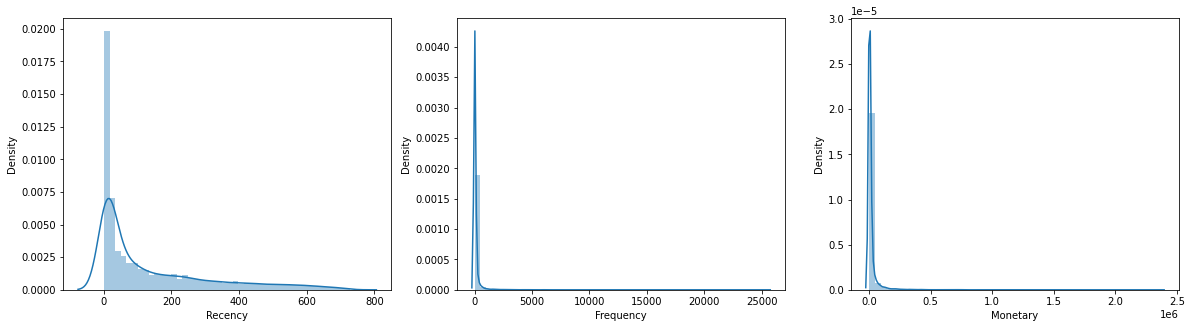

In [36]:
#Histogram Plot
fig, axes = plt.subplots(1,3, figsize = (20,5))
for i, feature in enumerate(list(df_rfm.columns)):
  sns.distplot(df_rfm[feature], ax=axes[i])

In [90]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,14351.000000,14351.000000,1.435100e+04
mean,137.961605,105.478294,1.633296e+04
std,174.498650,527.717966,6.431726e+04
min,1.000000,1.000000,2.010000e+00
25%,11.000000,3.000000,3.626300e+02
50%,52.000000,11.000000,1.602620e+03
75%,214.000000,45.000000,8.230995e+03
max,729.000000,25512.000000,2.369072e+06


In [95]:
#log transformation
df_rfm_log = np.log10(df_rfm)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

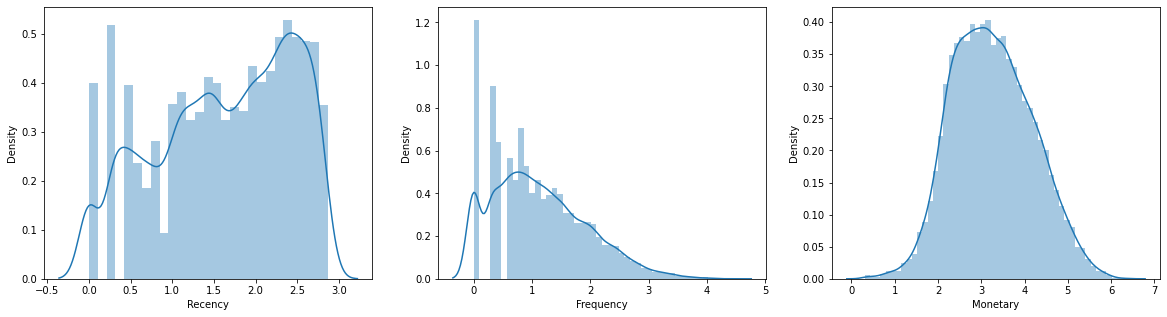

In [96]:
#Histogram Plot
fig, axes = plt.subplots(1,3, figsize = (20,5))
for i, feature in enumerate(list(df_rfm_log.columns)):
  sns.distplot(df_rfm_log[feature], ax=axes[i])

In [97]:
df_rfm_log.describe()

,Recency,Frequency,Monetary
count,14351.000000,14351.000000,14351.000000
mean,1.622074,1.126487,3.258910
std,0.808353,0.800771,0.929003
min,0.000000,0.000000,0.303196
25%,1.041393,0.477121,2.559464
50%,1.716003,1.041393,3.204831
75%,2.330414,1.653213,3.915452
max,2.862728,4.406745,6.374578


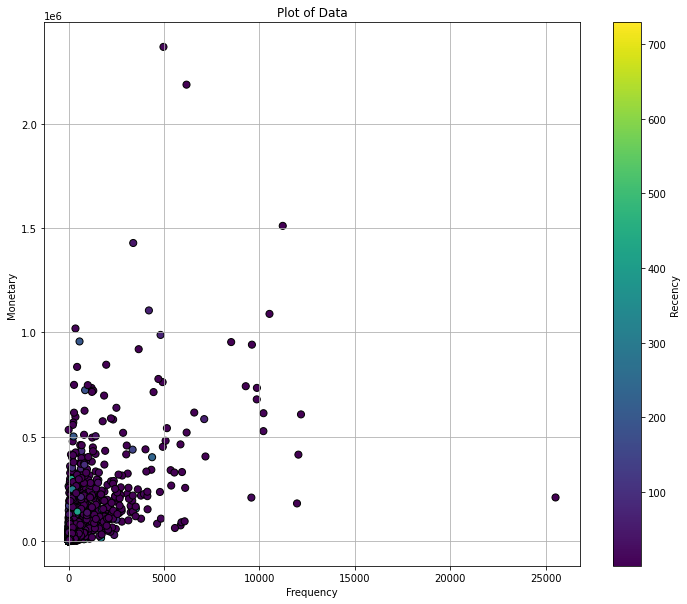

In [108]:
#2d plot of data with heatmap
X=df_rfm
plt.figure(figsize=(12,10))
plt.scatter(
   X[frequency], X[monetary],
   c=X[recency], marker='o',
   edgecolor='black', s=50
)
plt.title('Plot of Data')
plt.xlabel(frequency)
plt.ylabel(monetary)
plt.grid()
cbar = plt.colorbar()
cbar.set_label(recency)
plt.show()

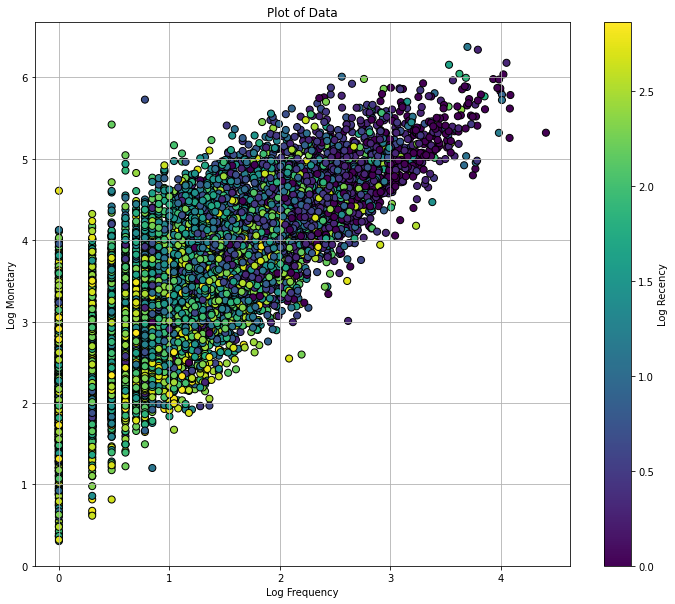

In [99]:
#2d plot of Log data with heatmap
X=df_rfm_log
plt.figure(figsize=(12,10))
plt.scatter(
   X[frequency], X[monetary],
   c=X[recency], marker='o',
   edgecolor='black', s=50
)
plt.title('Plot of Data')
plt.xlabel('Log '+frequency)
plt.ylabel('Log '+monetary)
plt.grid()
cbar = plt.colorbar()
cbar.set_label('Log '+recency)
plt.show()

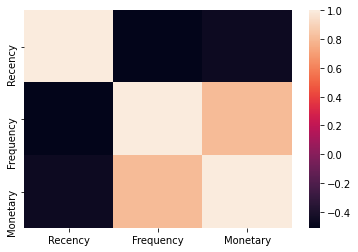

In [85]:
#feature correlation
sns.heatmap(df_rfm_log.corr())

**Modelling**

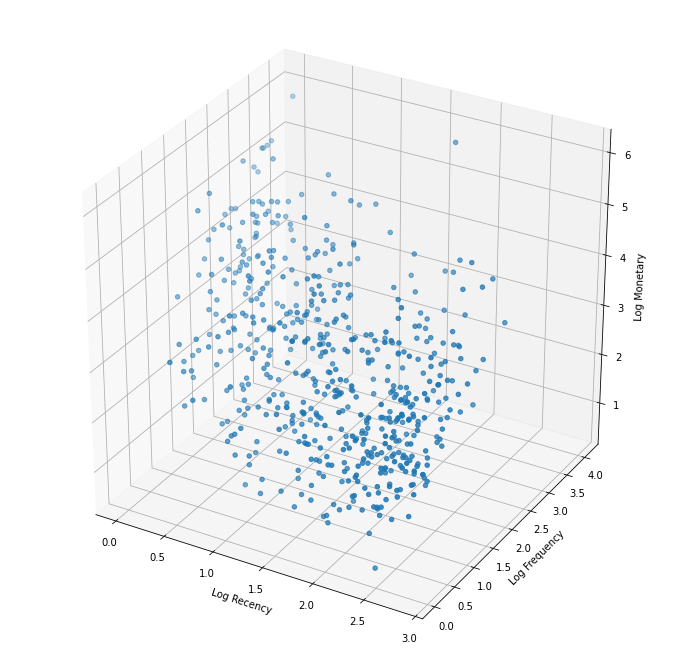

In [144]:
#3d plot of Log data
X_sample=df_rfm_log.sample(frac=0.04, random_state=1)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_sample[recency], X_sample[frequency], X_sample[monetary], cmap='viridis', marker='o')
ax.set_xlabel('Log '+recency)
ax.set_ylabel('Log '+frequency)
ax.set_zlabel('Log '+monetary)
plt.show()

<function matplotlib.pyplot.show>

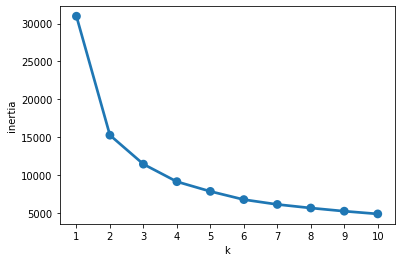

In [120]:
#k-means
SSE = []
for k in range(0,10):
  kmeans = KMeans(n_clusters=k+1, init='k-means++',random_state=0).fit(df_rfm_log)
  SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y = SSE)
plt.xlabel('k')
plt.ylabel('inertia')
plt.show

In [126]:
#model predictions
model = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(df_rfm_log)
df_rfm_final = df_rfm
df_rfm_final['Cluster'] = model.labels_
df_rfm_final

,Recency,Frequency,Monetary,Cluster
merchant,,,,
0002b63b92,595,1,33.79,0
0002d07bba,17,4,892.78,2
00057d4302,515,28,295.21,0
000bcff341,510,1,78.26,0
000ddbf0ca,578,1,102.99,0
...,...,...,...,...
ffd3e45675,704,5,726.26,0
ffe1f6b51a,316,53,2816.16,3
ffe26b900d,41,81,9591.13,3


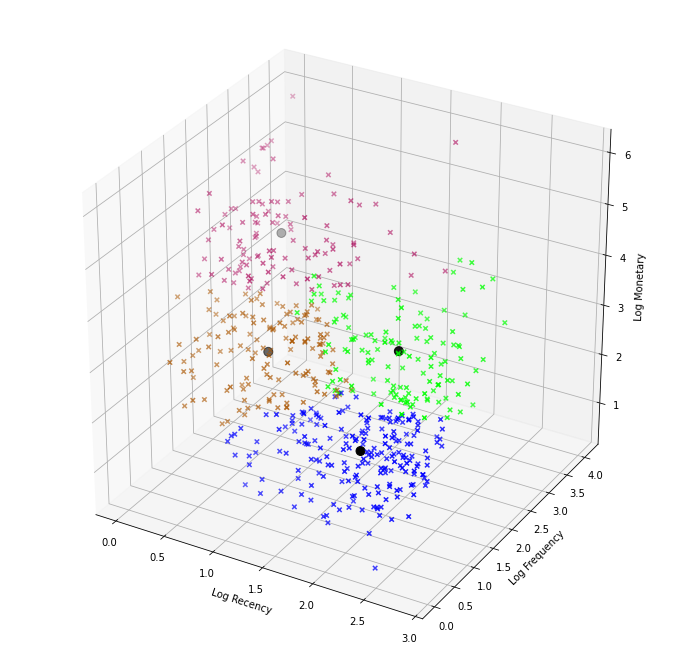

In [150]:
#3d plot of clusters
fig = plt.figure(figsize=(12,12))
centers = model.cluster_centers_
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_sample[recency], X_sample[frequency], X_sample[monetary], cmap="brg", c=model.predict(X_sample), marker='x', s=20)

ax.scatter(centers[:,0], centers[:,1],centers[:,2], c='black', s=80, marker='o')

ax.set_xlabel('Log '+recency)
ax.set_ylabel('Log '+frequency)
ax.set_zlabel('Log '+monetary)

plt.show()

**Results**

,Recency,Frequency,Monetary,Cluster Size
Cluster,,,,
0,232.848101,3.587223,392.237116,5056
1,10.348753,467.886881,69718.396979,2767
2,15.030303,17.700406,2651.202390,3201
3,218.172528,43.366396,9321.851178,3327


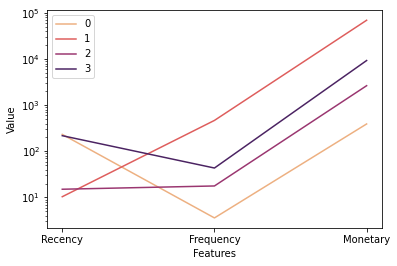

In [164]:
#final results
#table
df_rfm_clusters = df_rfm_final.groupby('Cluster').agg({recency: 'mean', frequency: 'mean', monetary: 'mean','Cluster':'count'})
df_rfm_clusters.columns = [recency,frequency,monetary,'Cluster Size']
display(df_rfm_clusters)
#lineplot
melted_rfm = pd.melt(df_rfm_clusters.reset_index(),id_vars=['Cluster'],value_vars=[recency,frequency,monetary],var_name='Features',value_name='Value')
sns.lineplot(x='Features',y='Value',hue='Cluster',data=melted_rfm, palette="flare")
plt.yscale("log")
plt.legend()

# *Merchant Churn Prediction*

In [176]:
#finding calibration period by finding quantiles of interpurchase average time
df_c = df.groupby('merchant').agg({'time': lambda x: (max(x)-min(x)).days, 'merchant': 'count'})
df_c.columns = ['time between first and last purchase','purchase count']
df_c['interpurchase average time'] = df_c['time between first and last purchase']/(df_c['purchase count'].apply(lambda x: x if x == 1 else x-1))
display(df_c)
df_c.quantile([0.5,0.75,0.8,0.9,0.95,0.975,0.99])

,time between first and last purchase,purchase count,interpurchase average time
merchant,,,
0002b63b92,0,1,0.000000
0002d07bba,65,4,21.666667
00057d4302,66,28,2.444444
000bcff341,0,1,0.000000
000ddbf0ca,0,1,0.000000
...,...,...,...
ffd3e45675,23,5,5.750000
ffe1f6b51a,260,53,5.000000
ffe26b900d,334,81,4.175000


,time between first and last purchase,purchase count,interpurchase average time
0.500,128.0,11.0,5.750000
0.750,348.0,45.0,20.000000
0.800,401.0,67.0,26.000000
0.900,523.0,176.0,49.857143
0.950,604.5,387.0,82.000000
0.975,658.0,757.0,119.850000
0.990,695.0,1800.5,197.250000


In [179]:
first = 'First Recency' #days to first purchase from last date of data
df_rfm_c=df_rfm.copy()
df_rfm_c[first] = df.groupby('merchant').agg({'time': lambda x: (recency_end_date-min(x)).days})
df_rfm_c

,Recency,Frequency,Monetary,Cluster,First Recency
merchant,,,,,
0002b63b92,595,1,33.79,0,594
0002d07bba,17,4,892.78,2,81
00057d4302,515,28,295.21,0,580
000bcff341,510,1,78.26,0,509
000ddbf0ca,578,1,102.99,0,577
...,...,...,...,...,...
ffd3e45675,704,5,726.26,0,726
ffe1f6b51a,316,53,2816.16,3,575
ffe26b900d,41,81,9591.13,3,374


In [185]:
first_date = min(df['time'])
prediction_period = 120 #in days out of 730
calibration_period_end_date_days = 365*2-prediction_period
calibration_period_end_date = min(df['time'])+dt.timedelta(days=calibration_period_end_date_days) # min(df['time']) = 01-01-2033
#calibration_period_half = (365*2-prediction_period)/2
df_include = df[df['time']<=calibration_period_end_date] #only include merchants that were active during the calibration period
df_include = df_include.groupby('merchant').agg({'time': [lambda x: (max(x)-min(x)).days, lambda x: (calibration_period_end_date-min(x)).days], 'merchant': 'count','amount_usd_in_cents':'sum'})
df_include.columns= ['Last Transaction','Time Alive',frequency,monetary]
#df_include=df_include[df_include['first purchase']<=calibration_period_half]
#df_include=df_include.drop(columns=['First Purchase'])
df_churn = df.groupby('merchant').agg({'time': lambda x: int( ((max(x)-first_date).days>calibration_period_end_date_days) == False )}) #find labels for churners using our definition
df_include['Churn']=df_churn
display(df_include)
df_include.describe()

,Last Transaction,Time Alive,Frequency,Monetary,Churn
merchant,,,,,
0002b63b92,0,475,1,33.79,1
00057d4302,66,461,28,295.21,1
000bcff341,0,390,1,78.26,1
000ddbf0ca,0,458,1,102.99,1
000ed1585f,549,562,59,15754.72,0
...,...,...,...,...,...
ffd3e45675,23,607,5,726.26,1
ffe1f6b51a,260,456,53,2816.16,1
ffe26b900d,254,255,53,7164.12,0


,Last Transaction,Time Alive,Frequency,Monetary,Churn
count,11630.000000,11630.000000,11630.000000,1.163000e+04,11630.000000
mean,165.279192,282.815219,89.671797,1.366230e+04,0.446776
std,169.446861,172.213088,458.658958,5.377734e+04,0.497180
min,0.000000,0.000000,1.000000,2.070000e+00,0.000000
25%,14.000000,133.000000,3.000000,3.392225e+02,0.000000
50%,105.000000,275.000000,10.000000,1.453295e+03,0.000000
75%,284.750000,428.000000,39.000000,7.376448e+03,1.000000
max,610.000000,610.000000,22350.000000,2.185458e+06,1.000000


In [186]:
df_data = df_include.drop(columns=['Churn'])
data = df_include.drop(columns=['Churn']).values
labels = df_include['Churn'].values

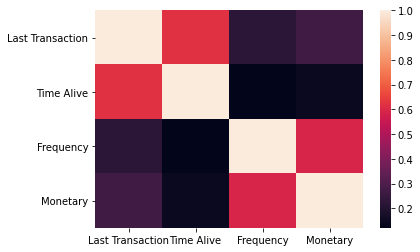

In [187]:
sns.heatmap(df_data.corr())

In [190]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,random_state = 20, test_size = 0.2)

scaler = StandardScaler() 
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [202]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 20,
                                                         class_weight='balanced')))
models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 20)))
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100, criterion = 'entropy', random_state = 0)))
models.append(('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)))

#Evaluating Model Results:

# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0
# Evaluate each model using k-fold cross-validation:
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, random_state=0)
    # accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(  
    model, X_train, y_train, cv=kfold, scoring='accuracy')
    # roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(  
    model, X_train, y_train, cv=kfold, scoring='roc_auc')
    model_results.loc[i] = [name,
                            round(cv_auc_results.mean()*100, 2),
                            round(cv_auc_results.std()*100, 2),
                            round(cv_acc_results.mean()*100, 2),
                            round(cv_acc_results.std()*100, 2)
                            ]
    i += 1
    
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
1,Kernel SVM,87.36,0.87,80.41,1.09
0,Logistic Regression,86.96,1.06,79.42,1.33
2,Random Forest,86.50,1.12,79.02,1.08
3,Gradient Boosting,86.39,1.02,78.60,1.20


In [230]:
#Evaluating Model Results:

# set table to table to populate with performance results
col = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score']
clf_results = pd.DataFrame(columns=col)

i=0
for name, classifier in models:

  classifier.fit(X_train,y_train)
  # Predict the Test set results
  y_pred = classifier.predict(X_test)
  #Evaluate Model Results on Test Set:
  clf_results.loc[i] = [name,
                            round(accuracy_score(y_test, y_pred ), 2),
                            round(precision_score(y_test, y_pred), 2),
                            round(recall_score(y_test, y_pred), 2),
                            round(f1_score(y_test, y_pred), 2),
                            round(fbeta_score(y_test, y_pred, beta=2.0),2)
                        ]
  i+=1

display(clf_results)

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,Logistic Regression,0.79,0.79,0.70,0.74,0.72
1,Kernel SVM,0.80,0.78,0.75,0.76,0.76
2,Random Forest,0.79,0.76,0.76,0.76,0.76
3,Gradient Boosting,0.78,0.79,0.68,0.73,0.70


In [241]:
classifier = SVC(kernel = 'rbf', random_state = 20, probability = True)
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [242]:
accuracies = cross_val_score(estimator = classifier,
 X = X_train, y = y_train, cv = 10)
print("Kernel SVM Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), 
accuracies.std() * 2))

Kernel SVM Classifier Accuracy: 0.80 (+/- 0.02)


In [222]:
# # Analyzing Coefficients
# feature_importances = pd.concat([pd.DataFrame(df_data.columns, columns = ["features"]),
# pd.DataFrame(np.transpose(classifier.coef_), 
# columns = ["coef"])],axis = 1)
# feature_importances.sort_values("coef", ascending = False)

Text(0.5, 7.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

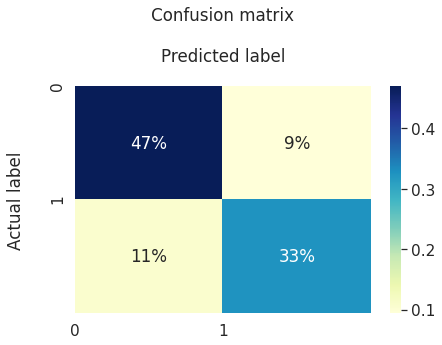

In [243]:
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm/np.sum(cm), annot=True, fmt='.0%',cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

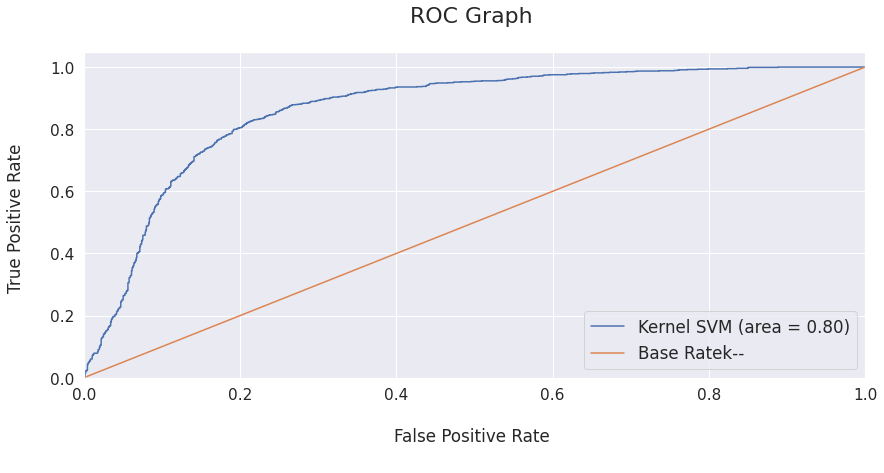

In [244]:
classifier.fit(X_train, y_train) 
probs = classifier.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Kernel SVM (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()